<h1>CV Project - Phase 2</h1>
<h4>Incremental SFM and Refinement</h4>

Disclaimer: Generative AI was used in certain parts of our implementation for debugging and optimization purposes. These parts have been flagged with comments

In [ ]:
import cv2
import numpy as np
import os
import glob
from scipy.optimize import least_squares
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from collections import defaultdict

import helper_fns_p1  #file where helper functions are defined 
import SFM  #file where SFM class is defined 

In [ ]:
#genAI - claude recommended redefining our 2-view initialization -> redefining our functin used in phase 1
# to better fit the multi-view / incremental sfm part.

def initialize_two_view(img_path1, img_path2, sfm): #establishes initial cameras and 3D points from the first 2 images.

    #feature detection and matching (SIFT / ORB)to find correspondences:    
    img1, gray1 = helper_fns_p1.load_gray(img_path1)
    img2, gray2 = helper_fns_p1.load_gray(img_path2)
    
    kps1, desc1 = helper_fns_p1.detect_and_describe(gray1)
    kps2, desc2 = helper_fns_p1.detect_and_describe(gray2)
    
    sfm.image_features[0] = {'kps': kps1, 'desc': desc1, 'img': img1}
    sfm.image_features[1] = {'kps': kps2, 'desc': desc2, 'img': img2}
    
    print(f"Keypoints: Image 0={len(kps1)}, Image 1={len(kps2)}")
    
    matches = helper_fns_p1.match_features(desc1, desc2)
    print(f"Good matches: {len(matches)}")
    
    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches])
    #estimating essential matrix using RANSAC ->
    E, mask = cv2.findEssentialMat(pts1, pts2, sfm.K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    #ransac filters outlier matches (incorrect correspondences), computes multiple Essential matrices , returns the best
    # matrix + inlier mask. 

    mask = mask.ravel().astype(bool)
    pts1_in = pts1[mask]
    pts2_in = pts2[mask]
    matches_in = [matches[i] for i in range(len(matches)) if mask[i]]
    print(f"Inliers after RANSAC: {len(pts1_in)}")
    
    #recovering camera pose : E -> R, t
    num_valid, R, t, pose_mask = cv2.recoverPose(E, pts1_in, pts2_in, sfm.K)
    print(f"Points with positive depth: {num_valid}")
    
    sfm.add_camera(0, np.eye(3), np.zeros((3, 1))) #setting up the initial cameras -> establish world view coord system
    sfm.add_camera(1, R, t)
    
    P1 = sfm.cameras[0]['P']
    P2 = sfm.cameras[1]['P']
    
    #triangulation
    pose_mask = pose_mask.ravel().astype(bool)
    pts1_v = pts1_in[pose_mask]
    pts2_v = pts2_in[pose_mask]
    matches_v = [matches_in[i] for i in range(len(matches_in)) if pose_mask[i]]
    
    points_3d = helper_fns_p1.triangulate_points(P1, P2, pts1_v, pts2_v)
    
    added = 0

    #validating and adding the points to the reconstruction
    for i, (pt3d, pt1, pt2, m) in enumerate(zip(points_3d, pts1_v, pts2_v, matches_v)):
        if pt3d[2] <= 0:
            continue
        pt_cam2 = R @ pt3d + t.ravel()
        if pt_cam2[2] <= 0:
            continue
        
        pt3d_h = np.append(pt3d, 1)
        proj1 = P1 @ pt3d_h; proj1 = proj1[:2] / proj1[2]
        proj2 = P2 @ pt3d_h; proj2 = proj2[:2] / proj2[2]
        
        err1 = np.linalg.norm(proj1 - pt1)
        err2 = np.linalg.norm(proj2 - pt2)
        
        if err1 < 5.0 and err2 < 5.0:
            x, y = int(pt1[0]), int(pt1[1])
            if 0 <= x < img1.shape[1] and 0 <= y < img1.shape[0]:
                color = img1[y, x][::-1].tolist()
            else:
                color = [128, 128, 128]
            
            point_idx = sfm.add_point(pt3d, color)
            sfm.add_observation(point_idx, 0, pt1, m.queryIdx)
            sfm.add_observation(point_idx, 1, pt2, m.trainIdx)
            added += 1
    
    print(f"Valid 3D points: {added}")
    return sfm

<h4>Incrementally Adding new views to the existing reconstruction</h4>
Defining functions:<br><br>
1. find_correspondences(sfm, new_kps, new_desc) -> computes 2d-3d correspondences  <br>
2. pose_estimation(sfm, points_3d, points_2d) -> perspective and point cv2.PnPRANSAC <br> 


In [21]:

def find_correpondences(sfm, new_kps, new_desc):
    all_points_3d = []  #storing the matched 3D points 
    all_points_2d = []  #storing the corresponding 2D points 
    all_match_info = []
    seen_points = set() #take this out
        
    for cam_idx in sorted(sfm.cameras.keys(), reverse=True):  #loop through all previously added cameras
        if cam_idx not in sfm.image_features: 
            continue
            
        prev = sfm.image_features[cam_idx]  #getting previous descriptors

        if prev['desc'] is None:
            continue
                
        matches = helper_fns_p1.match_features(new_desc, prev['desc'])  #match features
            
        for m in matches:  #iterate through matches 
            new_feat_idx = m.queryIdx
            prev_feat_idx = m.trainIdx
                
            #check if the  previous feature has an associated 3D point ->
            if prev_feat_idx in sfm.feature_to_point[cam_idx]:
                point_idx = sfm.feature_to_point[cam_idx][prev_feat_idx]
                    
                if point_idx not in seen_points:
                    seen_points.add(point_idx)
                    all_points_3d.append(sfm.points_3d[point_idx])
                    all_points_2d.append(new_kps[new_feat_idx].pt)
                    all_match_info.append((point_idx, new_feat_idx))
        
    if len(all_points_3d) == 0:
        return np.array([]).reshape(0, 3), np.array([]).reshape(0, 2), []
        
    return np.array(all_points_3d), np.array(all_points_2d), all_match_info

def pose_estimation(sfm, points_3d, points_2d):  
    #perspective n point -> pose computation

    # we need at least 6 points to use RANSAC
    if len(points_3d) < 6:
        return False, None, None, None
    
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        points_3d.astype(np.float64), 
        points_2d.astype(np.float64), 
        sfm.K, None,
        iterationsCount=2000,
        reprojectionError=8.0,
        confidence=0.999,
        flags=cv2.SOLVEPNP_EPNP  #using the efficient perspective n point algo
    )
    
    if not success or inliers is None or len(inliers) < 6:
        # Try again with iterative method
        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            points_3d.astype(np.float64), 
            points_2d.astype(np.float64), 
            sfm.K, None,
            iterationsCount=2000,
            reprojectionError=10.0,
            confidence=0.999,
            flags=cv2.SOLVEPNP_ITERATIVE
        )
    
    if not success or inliers is None:
        return False, None, None, None
    
    #GenAI - Use of cv2.Rodrigues() suggested by claude to convert rotation 
    # representation and flatten inliers before returning 
    R, _ = cv2.Rodrigues(rvec)
    return True, R, tvec, inliers.ravel()  #.ravel() -> inliers = 1D array


triangulate_new(sfm, new_img_idx, new_kps, new_desc, img)<br><br>
Extracts projection matrix -> P_new
Extracts Rotation, translation matrices -> R_new, t_new 

filters matches and performs validations/ checks to determine which points should be added to the reconstruction and which should be removed:<br>
- cheirality check <br>
- distance check <br>
- reprojection check <br>

In [16]:
def triangulate_new(sfm, new_img_idx, new_kps, new_desc, img):
    total_pts_added = 0
    new_feature_used = set()   #set to store which new features have already been triangualted

    P_new = sfm.cameras[new_img_idx]['P']
    R_new = sfm.cameras[new_img_idx]['R']
    t_new = sfm.cameras[new_img_idx]['t']

    #looping through all prev cameras -> matches features between new cam and prev cam descriptors
    for prev_idx in sorted(sfm.cameras.keys()):
        if prev_idx == new_img_idx:
            continue
        if prev_idx not in sfm.image_features:
            continue
        
        prev = sfm.image_features[prev_idx]
        if prev['desc'] is None:
            continue
        
        matches = helper_fns_p1.match_features(new_desc, prev['desc'])
        
        P_prev = sfm.cameras[prev_idx]['P']
        R_prev = sfm.cameras[prev_idx]['R']
        t_prev = sfm.cameras[prev_idx]['t']
        
        #filtering matches -> removes those where new feature has already been triangulated
        # or the prev feature already corresponds to an existing 3d point. 
        new_matches = []
        for m in matches:
            new_feat_idx = m.queryIdx
            prev_feat_idx = m.trainIdx
            
            if new_feat_idx in new_feature_used:
                continue
            
            if prev_feat_idx in sfm.feature_to_point[prev_idx]:
                continue
            
            new_matches.append(m)
        
    
        if len(new_matches) < 5:
            continue
        
        pts_prev = np.float32([prev['kps'][m.trainIdx].pt for m in new_matches])
        pts_new = np.float32([new_kps[m.queryIdx].pt for m in new_matches])
        
        points_3d = helper_fns_p1.triangulate_points(P_prev, P_new, pts_prev, pts_new)
        
        if len(points_3d) == 0:
            continue
        
        for i, (pt3d, pt_p, pt_n, m) in enumerate(zip(points_3d, pts_prev, pts_new, new_matches)):
            
            #Cheirality check -> transforming 3d pts to each camera's coordinate system
            pt_cam_prev = R_prev @ pt3d + t_prev.ravel()
            pt_cam_new = R_new @ pt3d + t_new.ravel()

            #points with z<=0 are behind the camera and impossible to see.
            # so using 0.5 as a safety margin
            if pt_cam_prev[2] <= 0.5 or pt_cam_new[2] <= 0.5:
                continue
            
            #distance check to filter out points that are too far -> 
            #calculating euclidean dist from world origin to point. 
            if np.linalg.norm(pt3d) > 200: #used 200 -> better for a room-scale reconstruction
                continue
            
            #genAI - claude suggested adding reprojection error check for validation

            #reprojection error check -> projecting the 3d point back into camera img
            # valid only if both reprojection errors are < 8 px
            pt3d_h = np.append(pt3d, 1)
            proj_p = P_prev @ pt3d_h
            proj_p = proj_p[:2] / proj_p[2]
            proj_n = P_new @ pt3d_h
            proj_n = proj_n[:2] / proj_n[2]
            
            err_prev = np.linalg.norm(proj_p - pt_p)
            err_new = np.linalg.norm(proj_n - pt_n)
            
            if err_prev < 8.0 and err_new < 8.0:
                #color extraction - > assigning each 3d point a color for when
                # we need to construct the point cloud.
                x, y = int(pt_n[0]), int(pt_n[1])
                if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                    color = img[y, x][::-1].tolist()
                else:
                    color = [128, 128, 128]
                
                #adding the new point to the reconstruction
                point_idx = sfm.add_point(pt3d, color)
                sfm.add_observation(point_idx, prev_idx, pt_p, m.trainIdx)
                sfm.add_observation(point_idx, new_img_idx, pt_n, m.queryIdx)
                
                new_feature_used.add(m.queryIdx)
                total_pts_added += 1
    
    return total_pts_added

<h4>Bundle Adjustment</h4>
Jointly refining camera poses and 3D point positions to minimize reprojection errors across all observations. 


In [5]:

#Cost computation function for Bundle Adjustment
def residuals(p, n_c, n_p, obs, K):
    res = []
    cams = []

    #extracting camera params from the flatteneed array (n_c)
    for i in range(n_c):
        rv = p[i*6:i*6+3]
        tv = p[i*6+3:i*6+6].reshape(3, 1)
        R, _ = cv2.Rodrigues(rv)
        cams.append({'R': R, 't': tv})

    #extracting 3d point params ->reshaping into nx3 array
    pts = p[n_c*6:].reshape(-1, 3)

    #computing reprojection error in each obs   
    for o in obs:
        pt3d = pts[o['pt']] #3d pt
        cam = cams[o['cam']] #camera
        pt2d = o['pt2d'] #2d location
        
        #building the projection matrix ->
        P = K @ np.hstack((cam['R'], cam['t']))
        #project 3d pts to 2d
        proj = P @ np.append(pt3d, 1)
        if proj[2] != 0:
            proj = proj[:2] / proj[2]
        else:
            proj = proj[:2]
        res.extend(proj - pt2d)
        
    return np.array(res)


def bundle_adjustment(sfm, fix_first_camera=True, max_points=5000):
    
    cam_indices = sorted(sfm.cameras.keys())
    #counting cameras and 3d points
    n_cams = len(cam_indices)
    n_pts = len(sfm.points_3d)
    
    if n_pts == 0:
        return
    
    #genAI - claude suggested using point subsampling to improve speed if pts are too many
    if n_pts > max_points:
        point_indices = np.random.choice(n_pts, max_points, replace=False)
        point_map = {old: new for new, old in enumerate(point_indices)}
    else:
        point_indices = list(range(n_pts))
        point_map = {i: i for i in range(n_pts)}
    
    #flattening camera parameters-> 
    #for each cam, +6 params -> Rotation: 3, translation:3

    params = []
    for cam_idx in cam_indices:
        R = sfm.cameras[cam_idx]['R']
        t = sfm.cameras[cam_idx]['t']
        rvec, _ = cv2.Rodrigues(R)
        params.extend(rvec.ravel())
        params.extend(t.ravel())
    
    #packing 3d point params -> appending all 3d pt. coords into the parameter array
    for pi in point_indices:
        params.extend(sfm.points_3d[pi])
    
    params = np.array(params)
    
    #building the observation list that links cameras to 3d points
    #Each obs:
    #which camera saw this point (idx flattened)
    #which 3d point was observed (idx)
    #where it was detected in the img (2d pt. coord)
    cam_map = {c: i for i, c in enumerate(cam_indices)}
    obs_list = []
    for (pt_idx, cam_idx), pt2d in sfm.observations.items():
        if cam_idx in cam_map and pt_idx in point_map:
            obs_list.append({
                'cam': cam_map[cam_idx], 
                'pt': point_map[pt_idx], 
                'pt2d': pt2d
            })
    
    #validation: counting total obs and exits if number of obs is less than 10
    n_obs = len(obs_list)
    n_pts_opt = len(point_indices)
    
    if n_obs < 10:
        return
    
    print(f"  BA: {n_cams} cams, {n_pts_opt} pts, {n_obs} obs")

    #creating sparse matrix (Jacobian sparsity aka matrix of derivatives)
    # shows how each residual changes accordign to each parameter. 
    # -> binary matrix where A[i j] = 1 means param j affects residual i, and 0 if o/w
    m = n_obs * 2
    n = n_cams * 6 + n_pts_opt * 3
    A = lil_matrix((m, n), dtype=int)
    
    for i, o in enumerate(obs_list):
        A[i*2:i*2+2, o['cam']*6:(o['cam']+1)*6] = 1
        pt_start = n_cams * 6 + o['pt'] * 3
        A[i*2:i*2+2, pt_start:pt_start+3] = 1
    
    #optimization
    result = least_squares(
        residuals, params,
        jac_sparsity=A,
        verbose=0, x_scale='jac', ftol=1e-3, method='trf',
        args=(n_cams, n_pts_opt, obs_list, sfm.K)
    )
    
    opt = result.x
    
    #updating camera poses:
    for i, cam_idx in enumerate(cam_indices):
        if fix_first_camera and i == 0:
            continue
        rv = opt[i*6:i*6+3]
        tv = opt[i*6+3:i*6+6].reshape(3, 1)
        R, _ = cv2.Rodrigues(rv)
        sfm.cameras[cam_idx]['R'] = R
        sfm.cameras[cam_idx]['t'] = tv
        sfm.cameras[cam_idx]['P'] = sfm.K @ np.hstack((R, tv))
    
    #updating 3d points:
    opt_pts = opt[n_cams*6:].reshape(-1, 3)
    for new_idx, old_idx in enumerate(point_indices):
        sfm.points_3d[old_idx] = opt_pts[new_idx].tolist()
    
    #computing final error: 
    final_res = residuals(result.x, n_cams, n_pts_opt, obs_list, sfm.K)
    rmse = np.sqrt(np.mean(final_res**2))
    print(f"  BA RMSE: {rmse:.4f} px")

In [ ]:


def run_incremental_sfm(image_paths):
    print(f"Processing {len(image_paths)} images")
    
    K, dims = helper_fns_p1.construct_intrinsic_matrix(image_paths[0])
    print(f"Image size: {dims[0]} x {dims[1]}")
    
    sfm = SFM.SfMReconstruction(K)
    sfm = initialize_two_view(image_paths[0], image_paths[1], sfm)
    bundle_adjustment(sfm)
    
    stats = []
    
    for i in range(2, len(image_paths)):
        # print(f"\n--- View {i}/{len(image_paths)-1} ---")
        
        img, gray = helper_fns_p1.load_gray(image_paths[i])
        kps, desc = helper_fns_p1.detect_and_describe(gray)
        sfm.image_features[i] = {'kps': kps, 'desc': desc, 'img': img}
        
        #Global matching against all cameras
        pts_3d, pts_2d, match_info = find_correpondences(sfm, kps, desc)
        
        print(f"  KP: {len(kps)}, 2D-3D: {len(pts_3d)}")
        
        #genAI - following 2 if conditions recommended to add by claude
        if len(pts_3d) < 10:
            print(f"  SKIP - insufficient correspondences")
            stats.append({'view': i, 'status': 'SKIP', 'corresp': len(pts_3d), 'new_pts': 0})
            continue
        
        success, R, t, inliers = pose_estimation(sfm, pts_3d, pts_2d)
        
        if not success:
            print(f"  SKIP - PnP failed")
            stats.append({'view': i, 'status': 'PnP_FAIL', 'corresp': len(pts_3d), 'new_pts': 0})
            continue
        
        print(f"  PnP OK: {len(inliers)} inliers")
        sfm.add_camera(i, R, t)
        
        #adding obs
        for j in inliers:
            pt_idx, feat_idx = match_info[j]
            sfm.add_observation(pt_idx, i, pts_2d[j], feat_idx)
        
        #triangulate the new points.
        pts_before = len(sfm.points_3d)
        num_new = triangulate_new(sfm, i, kps, desc, img)
        print(f"  New pts: {num_new}, Total: {len(sfm.points_3d)}")
        
        stats.append({
            'view': i, 
            'status': 'OK', 
            'corresp': len(pts_3d),
            'inliers': len(inliers),
            'new_pts': num_new,
            'total': len(sfm.points_3d),
            'cams': len(sfm.cameras)
        })
        
        #repeat the BA process after every 10 views-> 
        if len(sfm.cameras) % 10 == 0:
            bundle_adjustment(sfm)
    
    print("Bundle Adjustment\n")
    bundle_adjustment(sfm)
    
    successful = sum(1 for s in stats if s['status'] == 'OK')
    print(f"Successfully registered: {successful + 2}/{len(image_paths)} cameras")
    print(f"Total 3D points: {len(sfm.points_3d)}")
    print(f"Total observations: {len(sfm.observations)}")
    
    return sfm, stats

#genAI - claude generated the following function to generate and save the sparse 3d point cloud
def save_point_cloud_ply(filename, sfm):
    points = sfm.get_points_array()
    colors = sfm.get_colors_array()
    
    os.makedirs(os.path.dirname(filename) if os.path.dirname(filename) else ".", exist_ok=True)
    
    with open(filename, 'w') as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("property uchar red\nproperty uchar green\nproperty uchar blue\n")
        f.write("end_header\n")
        
        for pt, col in zip(points, colors):
            f.write(f"{pt[0]} {pt[1]} {pt[2]} {int(col[0])} {int(col[1])} {int(col[2])}\n")
    
    print(f"Saved {len(points)} points to {filename}")

#genAI - claude generated the following function to visualize output
def visualize(sfm, output_path=None):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    pts = sfm.get_points_array()
    if len(pts) > 0:
        cols = sfm.get_colors_array() / 255.0
        
        max_pts = 10000  #subsample for visualiation
        if len(pts) > max_pts:
            idx = np.random.choice(len(pts), max_pts, replace=False)
            pts, cols = pts[idx], cols[idx]
        
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=cols, s=1, alpha=0.5)
    
    for cam_idx, cam in sfm.cameras.items():
        C = -cam['R'].T @ cam['t']
        ax.scatter(C[0], C[1], C[2], c='red', s=80, marker='^')
        if cam_idx % 5 == 0:  #Label every 5th camera
            ax.text(C[0, 0], C[1, 0], C[2, 0], f'{cam_idx}', fontsize=7)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{len(sfm.cameras)} cameras, {len(sfm.points_3d)} points')
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

Found 69 images

ROBUST INCREMENTAL SFM
Processing 69 images
Image size: 960 x 1280

INITIALIZING TWO-VIEW RECONSTRUCTION
Keypoints: Image 0=1226, Image 1=1101
Good matches: 368
Inliers after RANSAC: 213
Points with positive depth: 212
Valid 3D points: 212
  BA: 2 cams, 212 pts, 424 obs
  BA RMSE: 0.1879 px

--- View 2/68 ---
  KP: 1123, 2D-3D: 111
  PnP OK: 86 inliers
  New pts: 169, Total: 381

--- View 3/68 ---
  KP: 1323, 2D-3D: 154
  PnP OK: 91 inliers
  New pts: 202, Total: 583

--- View 4/68 ---
  KP: 1505, 2D-3D: 190
  PnP OK: 79 inliers
  New pts: 171, Total: 754

--- View 5/68 ---
  KP: 1443, 2D-3D: 248
  PnP OK: 115 inliers
  New pts: 363, Total: 1117

--- View 6/68 ---
  KP: 1710, 2D-3D: 442
  PnP OK: 250 inliers
  New pts: 388, Total: 1505

--- View 7/68 ---
  KP: 1607, 2D-3D: 521
  PnP OK: 286 inliers
  New pts: 254, Total: 1759

--- View 8/68 ---
  KP: 1533, 2D-3D: 599
  PnP OK: 321 inliers
  New pts: 302, Total: 2061

--- View 9/68 ---
  KP: 1672, 2D-3D: 706
  PnP OK: 3

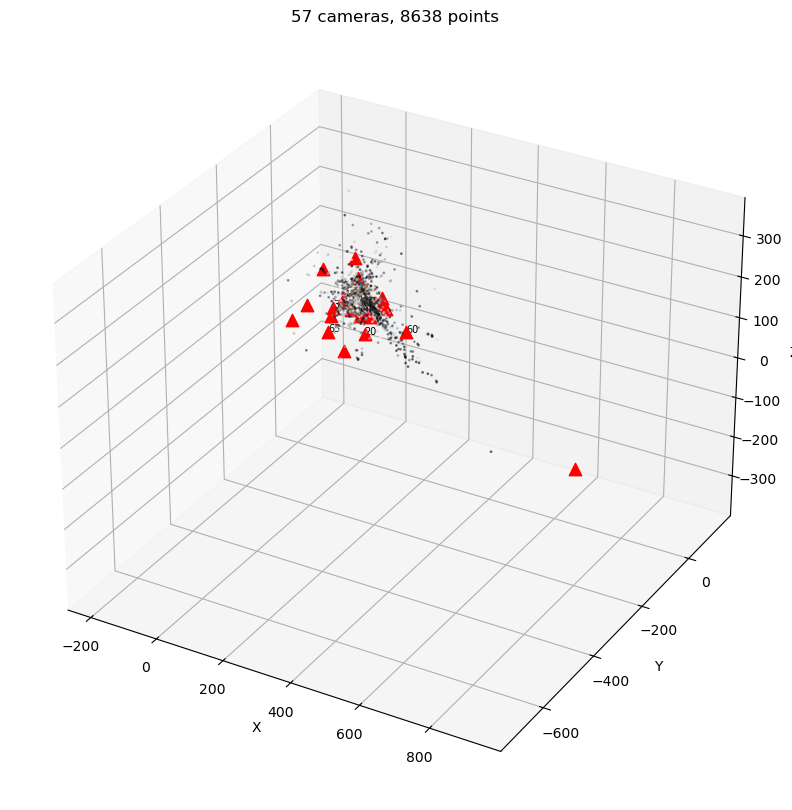

In [ ]:
os.makedirs("output", exist_ok=True)
    
image_paths = sorted(glob.glob("data/*.jpeg"))
print(f"Found {len(image_paths)} images")

#genAI - code was not executing -> claude suggested the following
if len(image_paths) >= 2:
    sfm, stats = run_incremental_sfm(image_paths)
    save_point_cloud_ply("output/robust_cloud.ply", sfm)
    visualize(sfm, "output/robust_visualization.png")
else:
    print("Need at least 2 images!")